In [1]:
import splat
import wisps
import matplotlib.pyplot as plt
from wisps.data_analysis import selection_criteria as sel_crt
from wisps.simulations import selection_function as slf
import numpy as np
import pandas as pd

import numba
import matplotlib as mpl
mpl.rcParams['font.size'] = 18

from itertools import combinations
#%%capture  output
import itertools
from tqdm import tqdm


import seaborn as sns 
cmap=sns.light_palette((260, 75, 60), input="husl", as_cmap=True)
from tensorflow import keras

from scipy import stats

In [2]:
%matplotlib inline

In [3]:
#read in some data
sf=pd.read_pickle(wisps.OUTPUT_FILES+'/selection_function.pkl.gz') #the simulated spectral data

In [4]:
#selection objects 
rfdict=pd.read_pickle(wisps.OUTPUT_FILES+'/random_forest_classifier.pkl') #the classifier 
indices_to_use= pd.read_pickle(wisps.OUTPUT_FILES+'/best_indices_to_use.pkl')
neural_network= keras.models.load_model(wisps.OUTPUT_FILES+'/deep_model_september23.h5')

In [5]:
#some formatting
sampled_data=pd.DataFrame.from_records(pd.DataFrame(sf).values.flatten())
sampled_data['sp_old']=np.vstack(sampled_data.sp_old.values)[:,0]
sampled_data['spt_new']=np.vstack(sampled_data.spt_new.values)[:,0]

In [6]:
#things that missed their classification 
sampled_data['missed_label']=sampled_data['sp_old'].apply(wisps.make_spt_number) != sampled_data['spt_new'].apply(wisps.make_spt_number)
sampled_data['missed_label']=1-sampled_data.missed_label.apply(int).apply(float)
sampled_data['Names']=['spctr'+ str(idx) for idx in sampled_data.index]
sampled_data['spt']=sampled_data['sp_old'].apply(wisps.make_spt_number)

In [7]:
#selection criteria
slc_crts=sel_crt.crts_from_file()

In [8]:
indices_to_use

[('CH_4/J-Cont H_2O-1+H_2O-2/J-Cont', 'M7-L0'),
 ('H_2O-1/J-Cont H_2O-2+CH_4/H-Cont', 'L0-L5'),
 ('CH_4/H_2O-2 H_2O-2+CH_4/J-Cont', 'L5-T0'),
 ('H_2O-1/J-Cont H_2O-2/H_2O-1', 'T0-T5'),
 ('H_2O-2/H_2O-1 H_2O-1+H_2O-2/J-Cont', 'T5-T9'),
 ('H_2O-1/J-Cont H_2O-2/H_2O-1', 'Y dwarfs'),
 ('H_2O-1/J-Cont CH_4/J-Cont', 'subdwarfs')]

In [9]:
#define a number of selectors 
#each selection should a column of zeros and ones corresponding
#to where objects were selected
#each selector input is the simulated df
def f_test_fx(x, df1, df2):
    return stats.f.cdf(x, df1, df2)

def select_by_indices(df, idx, spt_range):
    print(spt_range)
    bs=idx.shapes
    bx=[x for x in bs if x.shape_name==spt_range][0]
    _, bools= bx._select(np.array([df[idx.xkey].values, df[idx.ykey].values]))
    return bools
        

def apply_scale(x):
    ##remove nans 
    ##this is the same scaling used 
    ## same scaling used for 
    #replace nans
    y=x
    if np.isnan(y) or np.isinf(y) or abs(y) > 1e10:
        y=-99
    return y


def select_by_random_forest(df):
    #use the classification given by my rf classifier
    
    rf=rfdict['classifier']
    #min_max_scaler=rfdict['sclr']
    features=rfdict['feats']
    
    #apply logs to problematic features the same way I did on my classification
    pred_df=df.copy()
    
    for c in features:
        if c not in ['spt', 'f_test', 'x']:
            pred_df.assign(c=np.log10(pred_df[c].apply(apply_scale)))
        else:
            pred_df.assign(c=pred_df[c].apply(apply_scale))
            
    pred_df[features]=pred_df[features].applymap(apply_scale)
    #make predictions
    probs=rf.predict_proba(pred_df[features].values)
    
    #use my selection probability cutoffs
    #return the predictions
    
    labels=np.logical_or.reduce((probs[:, 2] > .8, probs[:,3] >.8 , probs[:,4] >0.85))
 
    return labels



def select_by_neuralnet(df):
    #define features (start with indices alone)
    #apply logs to problematic features the same way I did on my classification
    features=rfdict['feats']
    
    pred_df=df.copy()
    
    for c in features:
        if c not in ['spt']:
            pred_df.assign(c=np.log10(pred_df[c].apply(apply_scale)))
        else:
            pred_df.assign(c=pred_df[c].apply(apply_scale))
            
    pred_df[features]=pred_df[features].applymap(apply_scale)
    probs= neural_network.predict(  pred_df[features].values)
    
    #my cuts
    labels=np.logical_or.reduce((probs[:, 2] > .95, probs[:,3] >.95 , probs[:,4] >0.8))
    #labels=probs[:,0] <0.5
 
    return labels


In [16]:
df=wisps.Annotator.reformat_table(sampled_data)
#indices
for idxk, k in indices_to_use:
    idx=slc_crts[idxk]
    df['selected_by_{}'.format(k)]= select_by_indices(df, idx, k)

M7-L0
L0-L5
L5-T0
T0-T5
T5-T9
Y dwarfs
subdwarfs


array(['M7-L0', 'L0-L5', 'L5-T0', 'T0-T5', 'T5-T9', 'Y dwarfs',
       'subdwarfs'], dtype='<U34')

In [18]:
df['x']=df.spex_chi/df.line_chi
df['f_test']= f_test_fx(df.x, df.dof-2, df.dof-2)

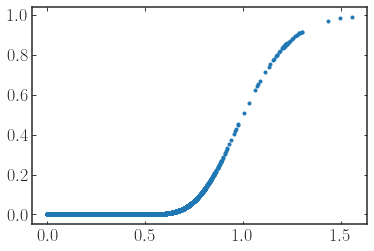

In [19]:
plt.plot(df.spex_chi/df.line_chi, df.f_test, '.')

In [20]:
df['f_test_label']=np.logical_and.reduce([df.f_test<0.02, df.x <0.5, df.snr1>=3.])

In [21]:
#select by indices before putting on a log-scale

In [57]:
#machine learning
df['rf_label']=select_by_random_forest(wisps.Annotator.reformat_table(df))
df['neural_net_label']=select_by_neuralnet(wisps.Annotator.reformat_table(df))

df['rf_label']=np.logical_and(df['rf_label'], df.snr1>=3. ).apply(int)
df['neural_net_label']=np.logical_and(df['neural_net_label'], df.snr1>=3. ).apply(int)

In [58]:
#indices and total
df.f_test_label=(df['f_test_label']).apply(int)

df['index_label']=np.logical_or.reduce([df['selected_by_{}'.format(x)].values for x in  np.vstack(indices_to_use)[:,1]]).astype(int)
df['idx_ft_label']=np.logical_and(df['index_label'].apply(bool), df['f_test_label'].apply(bool) ).apply(int)


df['tot_label']=np.logical_or.reduce((df['idx_ft_label'].apply(bool), df['rf_label'].apply(bool), df['neural_net_label'].apply(bool)))
df.tot_label=np.logical_and(df.tot_label.values, (df.snr1>=3.).values).astype(int)

#put things on log-scale
df['logsnr']=df['snr1'].apply(np.log10)

In [49]:
import seaborn as sns

In [52]:
cmap=sns.color_palette("cubehelix", as_cmap=True)

TypeError: color_palette() got an unexpected keyword argument 'as_cmap'

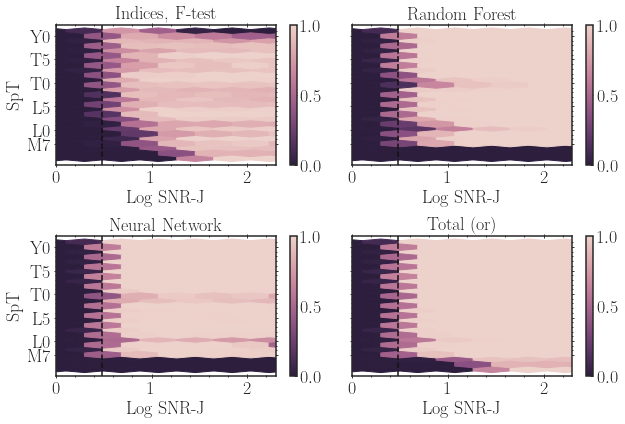

In [59]:
fig, ax=plt.subplots(ncols=2, nrows=2, figsize=(6*1.5, 4*1.5), sharex=False, sharey=True)
df.plot.hexbin(x='logsnr', y='spt', C='idx_ft_label', reduce_C_function=np.nanmean, gridsize=23, cmap=cmap, ax=ax[0][0])
df.plot.hexbin(x='logsnr', y='spt', C='rf_label', reduce_C_function=np.nanmean, gridsize=23, cmap=cmap, ax=ax[0][1])
df.plot.hexbin(x='logsnr', y='spt', C='neural_net_label', reduce_C_function=np.nanmean, gridsize=23, cmap=cmap, ax=ax[1][0])
df.plot.hexbin(x='logsnr', y='spt', C='tot_label', reduce_C_function=np.nanmean, gridsize=23, cmap=cmap, ax=ax[1][1])

#ax[0][0].scatter( sf.data.snr1.apply(np.log10), sf.data.spt, marker='+', color='#111111', alpha=.05)


ax[0][0].set_title('Indices, F-test ', fontsize=18)
ax[0][1].set_title('Random Forest', fontsize=18)
ax[1][0].set_title('Neural Network', fontsize=18)
ax[1][1].set_title('Total (or) ', fontsize=18)

for a in np.concatenate(ax):
    a.set_xlabel('Log SNR-J', fontsize=18)
    a.set_ylabel('SpT', fontsize=18)
    a.axvline(np.log10(3), linestyle='--', color='#111111')
    

    a.tick_params(which='major',direction='inout')
    a.tick_params(which='minor',direction='inout')
    
    a.minorticks_on()
    a.set_yticks(np.arange(17, 42),  minor=True)
    a.set_yticks([17, 20, 25, 30, 35, 40], minor=False)
    a.set_yticklabels(['M7', 'L0', 'L5', 'T0', 'T5', 'Y0'], minor=False)
    a.set_xlim([0., 2.3])
    #a.set_ylim([17., 42.])
    
plt.tight_layout()


plt.savefig(wisps.OUTPUT_FIGURES+'/selection_function_samples.pdf', bbox_inches='tight', dpi=200)

In [33]:
#save partial of the data to use for my selection function calculations
df2=(df[['logsnr', 'tot_label', 'spt']])

In [54]:
df2.to_pickle(wisps.OUTPUT_FILES+'/selection_function_lookup_table.pkl')

In [ ]:
fig, ax=plt.subplots(ncols=3, nrows=2, figsize=(8*1.5, 4*1.5), sharex=False, sharey=True)

for a, grp in zip(np.concatenate(ax), indices_to_use.values() ):
    c=a.scatter(df.spt, df.logsnr, c=df['selected_by_{}'.format(grp)], s=1., cmap='viridis')
    
    a.set_title(grp, fontsize=18)

    #a.set_xlabel('Log SNR-J', fontsize=18)
    #a.set_ylabel('SpT', fontsize=18)
    a.set_ylim([-1.5, 2.5])

#plt.colorbar(c)
    
plt.tight_layout()

In [ ]:
spex=wisps.datasets['spex']
spex=wisps.Annotator.reformat_table(spex)

In [ ]:
inv_indices_to_use={v: k for k, v in indices_to_use.items()}

In [ ]:
inv_indices_to_use

In [ ]:
df=wisps.Annotator.reformat_table(df)
tpls=wisps.Annotator.reformat_table(wisps.datasets['spex'])

In [ ]:
fig, ax=plt.subplots(ncols=3, nrows=2, figsize=(8*1.5, 4*1.5), sharex=False, sharey=True)

for a, grp in zip(np.concatenate(ax), indices_to_use.values() ):
    
    bx=None
    bs=None

    idx_label=inv_indices_to_use[grp]
    
    idx=slc_crts[idx_label]
    
    bs=idx.shapes
    bx=[x for x in bs if x.shape_name==grp][0]
    
   
    c=a.scatter(spex[idx.xkey], spex[idx.ykey], s=100., c='r')
    c=a.scatter(df[idx.xkey], df[idx.ykey], c=df['selected_by_{}'.format(grp)], s=1., cmap='viridis')
    
    bx.plot(ax=a,  only_shape=True, highlight=True)
    
    a.set_title(grp, fontsize=18)

    a.set_xlim([ bx.xrange[0]-1.5*abs(np.ptp(bx.xrange)), bx.xrange[1]+1.5*abs(np.ptp(bx.xrange))])
    a.set_ylim([ bx.yrange[0]-1.5*abs(np.ptp(bx.yrange)), bx.yrange[1]+1.5*abs(np.ptp(bx.yrange))])

    #a.set_xlabel('Log SNR-J', fontsize=18)


#plt.colorbar(c)
    
plt.tight_layout()

In [ ]:
np.array(nbrs['baraffe2003']).shape